# XG Boost Regressor Model - APPL Stock Prediction

In [5]:
#!pip install xgboost

In [6]:
pip install hvplot

In [7]:
#Importing Libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from xgboost import XGBRegressor
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt

In [8]:
# Read APPL.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
df = pd.read_csv('TSLA.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2021-01-25,855.000000,900.400024,838.820007,880.799988,880.799988,41173400,0.055793,1247
2021-01-26,891.380005,895.900024,871.599976,883.090027,883.090027,23131600,0.031129,1194
2021-01-27,870.349976,891.500000,858.659973,864.159973,864.159973,27334000,0.024594,907
2021-01-28,820.000000,848.000000,801.000000,835.429993,835.429993,26378000,0.048566,528
2021-01-29,830.000000,842.409973,780.099976,793.530029,793.530029,34990800,0.105722,428


In [9]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2018-01-02,64.106003,0.095630,839
2018-01-03,63.450001,0.112818,933
2018-01-04,62.924000,0.131831,851
2018-01-05,63.316002,0.105427,280
2018-01-08,67.281998,0.143506,851


In [10]:
# pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
df.dropna(inplace = True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2018-01-03,63.450001,0.112818,933,-0.010233
2018-01-04,62.924000,0.131831,851,-0.008290
2018-01-05,63.316002,0.105427,280,0.006230
2018-01-08,67.281998,0.143506,851,0.062638
2018-01-09,66.737999,0.123450,1023,-0.008085


### Creating the Features `X` and Target `y` Data

The first step towards preparing the data was to create the input features `X` and the target vector `y`. We used the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [11]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [12]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [13]:
# Use 70% of the data for training and 30% for testing
X_split = int(0.8 * len(X))
y_split = int(0.8 * len(y))

# Set X_train, X_test, y_train, t_test
X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

# Scaling Data with `MinMaxScaler`

We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.
Note that we scale both features and target sets.

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [16]:
# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [17]:
# Fit the model
model.fit(X_train, y_train.ravel())

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

---

---

## Model Performance

In this section, we will evaluate the model using the test data. 

We will:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart


In [18]:
# Make some predictions
predicted = model.predict(X_test)

In [19]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.041744171382483916
R-squared : 0.974119109715336


In [20]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-06-19,200.179993,203.654465
2020-06-22,198.863998,199.448532
2020-06-23,200.356003,203.113297
2020-06-24,192.169998,199.991791
2020-06-25,197.195999,203.784332


In [22]:
# Plot the real vs predicted values as a line chart
#stocks.hvplot.line(x="Date",y="Real",title = "Real vs Predicted values of APPL")
hvplot.show(stocks.hvplot(x="Predicted",y="Real"))

Launching server at http://localhost:34307


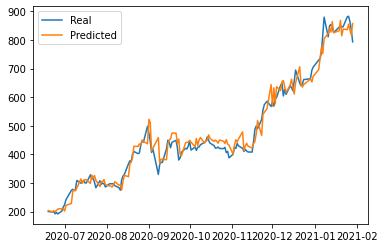

In [23]:
plt.plot(stocks)
plt.legend(["Real", "Predicted"], loc ="upper left")
plt.show()

In [24]:

# example of calculate the mean squared error
from sklearn.metrics import mean_squared_error
errors = mean_squared_error(stocks["Real"], stocks["Predicted"])
# report error
print(errors)

832.3888287905354
